In [5]:
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
from matplotlib import pyplot as plt

from one.api import ONE
from psyfun import io, plots
from psyfun.config import paths, qc_datasets

# Database query

In [2]:
# Instantiate database connection
mode = 'auto'  # sets mode for all queries (one.seach* methods)
one = ONE(mode=mode)

In [87]:
# Query the database for all sessions associated with this project
df_sessions = io.fetch_sessions(one, save=True)

100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 116.24it/s]


In [3]:
# Query the database for all probe insertions associated with this project
df_insertions = io.fetch_insertions(one, save=True)

100%|██████████████████████████████████████████| 53/53 [00:00<00:00, 858.21it/s]


In [3]:
# Load session and insertion info from file if already downloaded
df_sessions = pd.read_csv(paths['sessions'])
df_insertions = pd.read_csv(paths['insertions'])

# Quality control

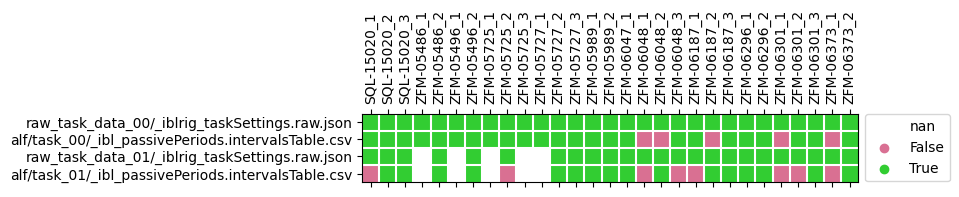

In [5]:
# Check which task datasets exist for each session
qc_columns = qc_datasets['task00'] + qc_datasets['task01']
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, qcval2num=qcval2num, xticklabels=xticklabels)

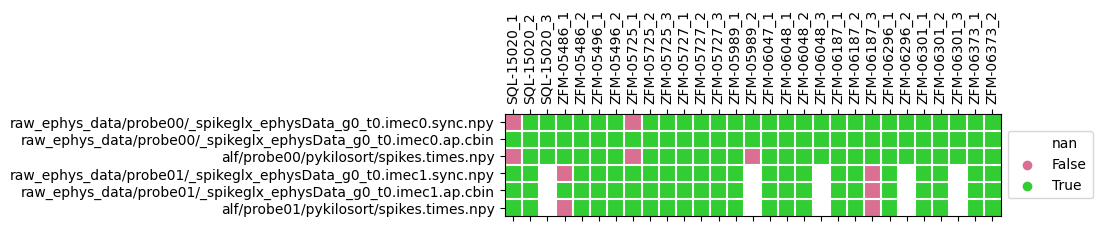

In [6]:
# Check which ephys datasets exist for each session
qc_columns = qc_datasets['probe00'] + qc_datasets['probe01']
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, qcval2num=qcval2num, xticklabels=xticklabels)

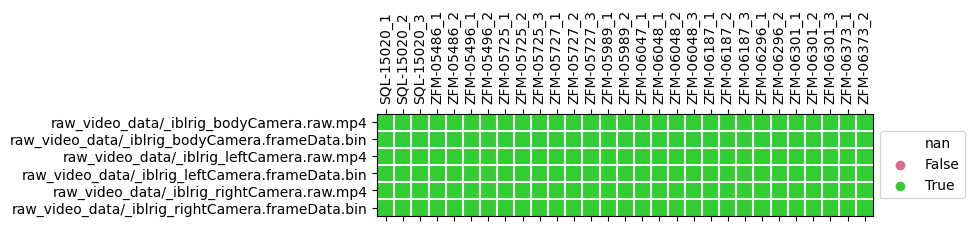

In [7]:
# Check which video datasets exist for each session
qc_columns = qc_datasets['video']
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns,  qcval2num=qcval2num, xticklabels=xticklabels)

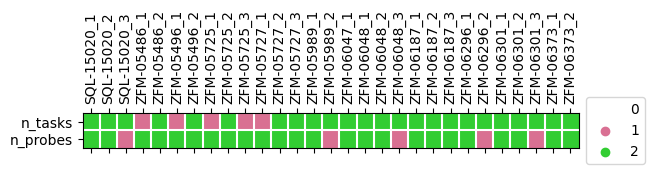

In [17]:
# Check which sessions have the appropriate number of probes and tasks
qc_columns = ['n_tasks', 'n_probes']
qcval2num = {0: 0., 1: 0.1, 2: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns=qc_columns, qcval2num=qcval2num, xticklabels=xticklabels)

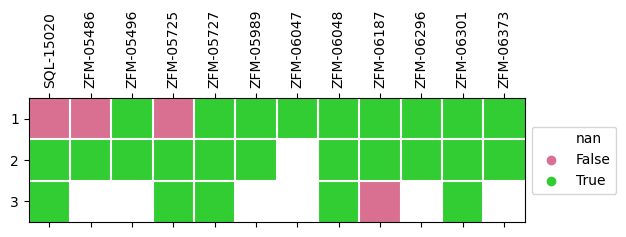

In [18]:
# Check which sessions have all the expected raw data
raw_cols = [col for col in df_sessions.columns if col.startswith('raw')]
df_sessions['data_complete'] = df_sessions.apply(lambda x: x[raw_cols].dropna().all(), axis='columns')
sessions_pivot = df_sessions.pivot(columns='session_n', index='subject', values='data_complete')
sessions_pivot = sessions_pivot.rename_axis(None, axis='columns')
ax = plots.qc_grid(sessions_pivot, qcval2num={np.nan: 0., False: 0.1, True: 1.})
ax.set_xticklabels(sessions_pivot.index)
ax.tick_params(axis='x', rotation=90)

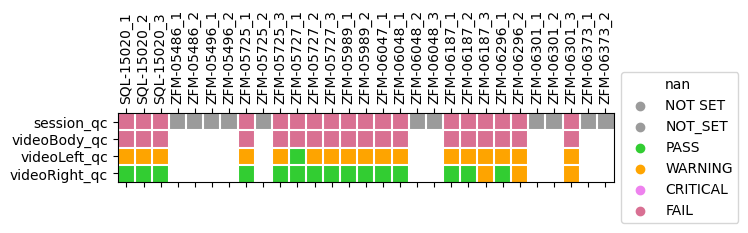

In [19]:
# Plot QC summary for the task and video
qc_columns = ['session_qc', 'videoBody_qc', 'videoLeft_qc', 'videoRight_qc']
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, xticklabels=xticklabels)

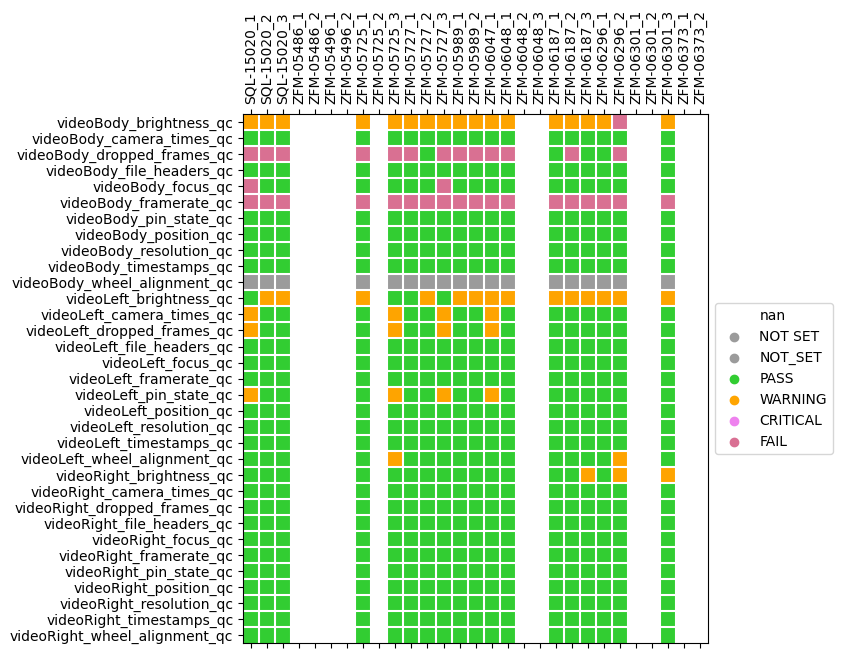

In [20]:
# Plot detailed video QC for each session
fig, ax = plt.subplots(figsize=(6, 8))
qc_columns = [col for col in df_sessions.columns if ('qc' in col) & (col.count('_') > 1)]
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns=qc_columns, ax=ax, xticklabels=xticklabels)

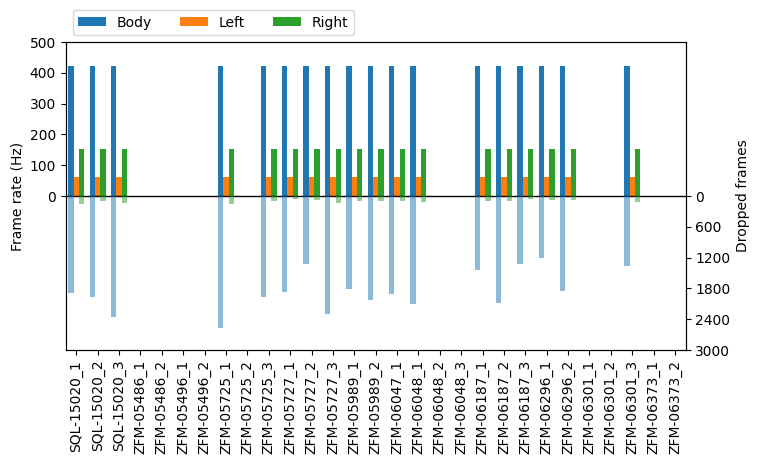

In [21]:
# Plot frame rate and number of dropped frames for each session & camera
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

xpos = np.arange(len(df_sessions))

for offset, camera in zip([-0.25, 0., 0.25], ['Body', 'Left', 'Right']):
    framerate = df_sessions[f'video{camera}_framerate']
    ax.bar(xpos + offset, framerate, width=0.25, label=camera)
    dropped_frames = df_sessions[f'video{camera}_dropped_frames']
    ax2.bar(xpos + offset, -1 * dropped_frames, width=0.25, alpha=0.5)

ax.legend(loc='lower left', bbox_to_anchor=(0., 1.), ncol=3)

ax.set_xlim([-0.5, len(df_sessions) - 0.5])
ax.set_ylim([-500, 500])
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_ylabel('Frame rate (Hz)')
ax2.set_ylim([-3000, 3000])
ax2.set_yticks(-1 * np.linspace(0, 3000, 6))
ax2.set_yticklabels(np.linspace(0, 3000, 6).astype(int))
ax2.set_ylabel('Dropped frames')
ax.axhline(0, color='black', lw=1)

ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)

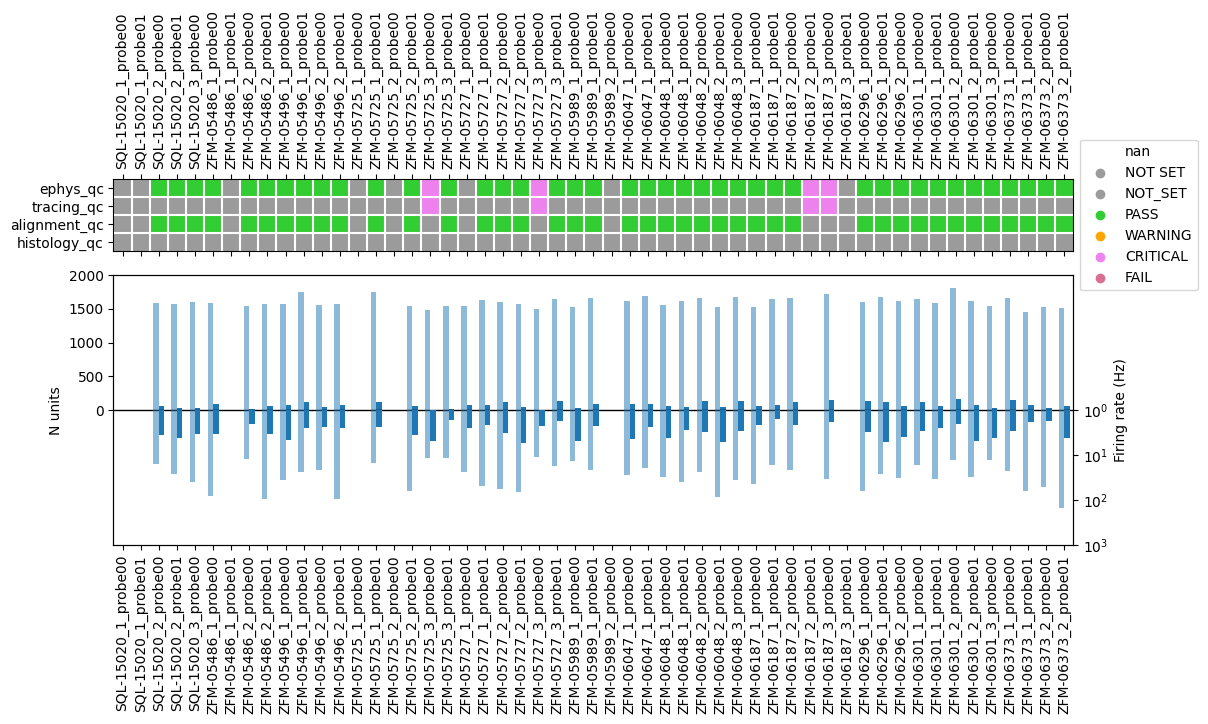

In [91]:
# Plot detailed ephys QC for ech session/probe
fig = plt.figure(figsize=(12, 6))
axs = [
    fig.add_axes([0.1, 0.5, 0.8, 0.3]),
    fig.add_axes([0.1, 0.1, 0.8, 0.45])
]

# Sort by subject
df_insertions = df_insertions.sort_values(['subject', 'session_n', 'probe'])

# QC grid plot
qc_columns = [col for col in df_insertions.columns if col.endswith('_qc')]
xticklabels = ['subject', 'session_n', 'probe']
axs[0] = plots.qc_grid(df_insertions, qc_columns, ax=axs[0], xticklabels=xticklabels)


# Bar plots for N units and firing rates
ax2 = axs[1].twinx()
xpos = np.arange(len(df_insertions))
offests = [-0.15, 0.15]
alphas = [0.5, 1.]
units_cols = ['n_units', 'n_units_qc_pass']
rate_cols = ['firing_rate_max', 'firing_rate_median']
for offset, units_col, rate_col, alpha in zip(offests, units_cols, rate_cols, alphas):
    n_units = df_insertions[units_col]
    axs[1].bar(xpos + offset, n_units, width=0.3, color='C0', alpha=alpha)
    firing_rate = df_insertions[rate_col]
    ax2.bar(xpos + offset, -1 * np.log10(firing_rate),  width=0.3, color='C0', alpha=alpha)
axs[1].set_xlim([-0.5, len(df_insertions) - 0.5])
axs[1].set_ylim([-2000, 2000])
axs[1].set_yticks(np.linspace(0, 2000, 5))
axs[1].set_ylabel('N units')
ax2.set_ylim([-3, 3])
ax2.set_yticks(-1 * np.linspace(0, 3, 4))
ax2.set_yticklabels(f'$10^{tick}$' for tick in np.linspace(0, 3, 4).astype(int))
ax2.set_ylabel('Firing rate (Hz)')
axs[1].axhline(0, color='black', lw=1)
axs[1].set_xticks(np.arange(len(df_insertions)))
axs[1].set_xticklabels(df_insertions.apply(lambda x: f"{x['subject']}_{x['session_n']}_{x['probe']}", axis='columns'))
axs[1].tick_params(axis='x', rotation=90)

Text(0.5, 0, 'Time from LSD administration (min)')

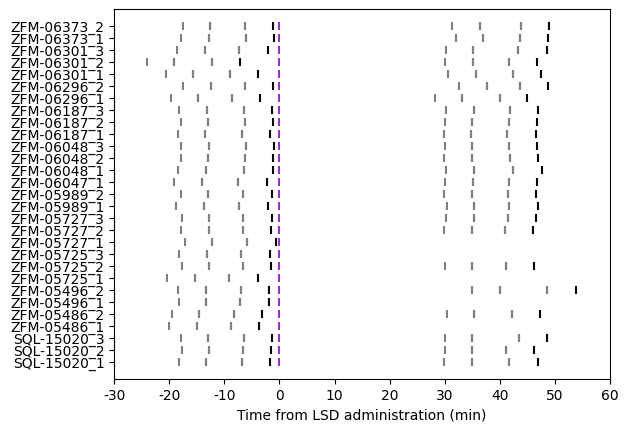

In [20]:
# Plot protocol timings for all sessions
epochs = ['spontaneous', 'rfm', 'replay']
fig, ax = plt.subplots()
for idx, session in df_sessions.iterrows():
    t0 = session['LSD_admin']
    ax.scatter(0, idx, marker='|', color='darkorchid')
    for task in ['task00', 'task01']:
        for epoch in epochs:
            ax.scatter(session[f'{task}_{epoch}_start'] - t0, idx, marker='|', color='gray')
            ax.scatter(session[f'{task}_{epoch}_stop'] - t0, idx, marker='|', color='black')
ax.set_yticks(np.arange(len(df_sessions)))
ax.set_yticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.set_xticks(np.linspace(-30, 60, 10) * 60)
ax.set_xticklabels(np.linspace(-30, 60, 10).astype(int))
ax.set_xlabel('Time from LSD administration (min)')

# Fetch spike data

In [ ]:
# Choose to save spike times as well as cluster info
spike_file = paths['spikes']  # download spike times and save to file
# spike_file = ''  # only fetch cluster info

# Download cluster info and spike times from server
df_units = io.fetch_units(one, df_insertions, uuid_file=paths['units'], spike_file=spike_file)

  2%|██▍                                                                                                                              | 1/53 [00:00<00:38,  1.34it/s]

2025-03-10 17:07:29 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01


 25%|███████████████████████████████▍                                                                                                | 13/53 [01:01<04:24,  6.62s/it]

In [4]:
# Load cluster info from file
df_units = pd.read_parquet(paths['units'])

In [22]:
df_units['acronym'] = df_units['acronym'].replace({'none': np.nan})
df_units = df_units.dropna(subset='acronym')

coarse_regions = combine_regions(df_units['acronym'])
region_counts = df_units.groupby('acronym').apply(len).sort_values(ascending=False)

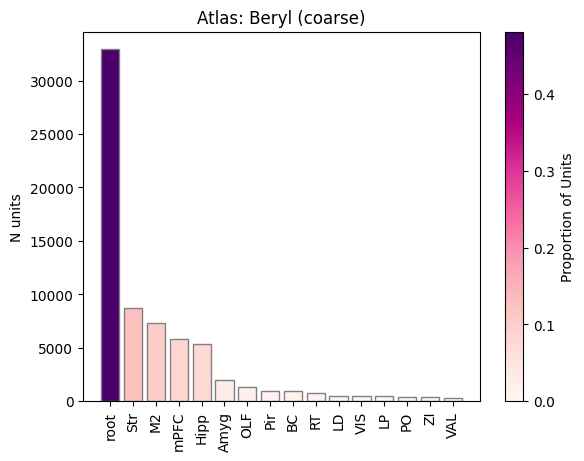

In [88]:
fig, ax = plt.subplots()
ax.set_title('Atlas: Beryl (coarse)')
cmap = cmaps['n_units']

region_names, counts = np.unique(coarse_regions, return_counts=True)
sorted_inds = np.argsort(-1 * counts)
props = counts / counts.sum()
colors = np.array([cmap(p) for p in props / props.max()])

ax.bar(np.arange(len(counts)), counts[sorted_inds], fc=colors[sorted_inds], ec='gray')
ax.tick_params(axis='x', rotation=90)
ax.set_xticks(np.arange(len(counts)))
ax.set_xticklabels(region_names[sorted_inds])
ax.set_ylabel('N units')

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, props.max()), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')

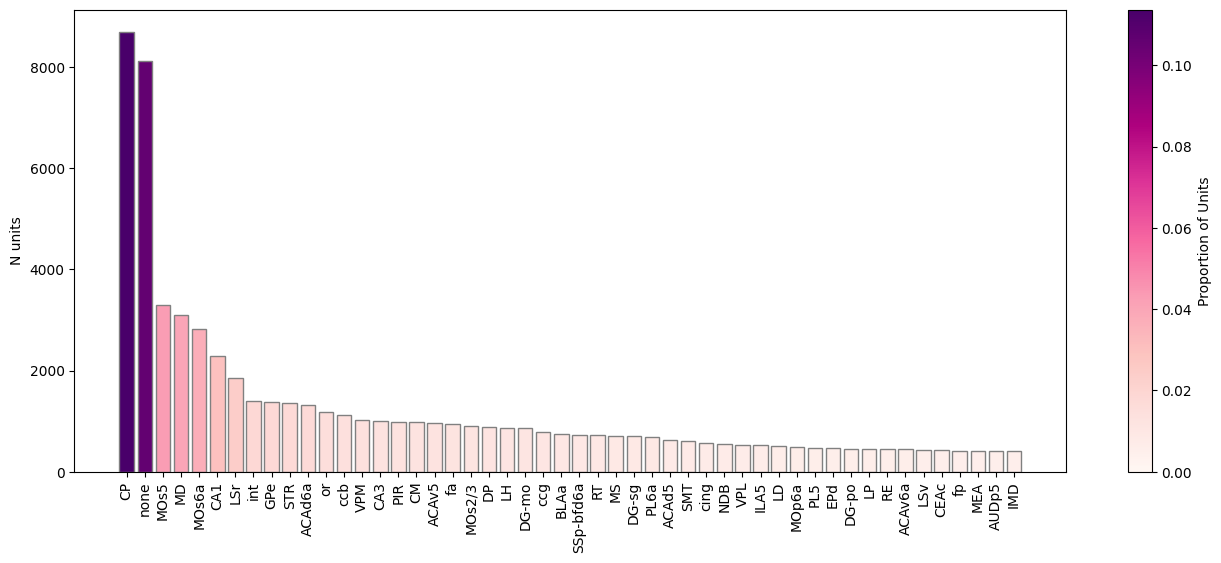

In [89]:
fig, ax = plt.subplots(figsize=(16, 6))
cmap = cmaps['n_units']
n_regions = 50

props = region_counts / region_counts.sum()
colors = np.array([cmap(p) for p in props / props.max()])

ax.bar(np.arange(n_regions), region_counts[:n_regions], fc=colors[:n_regions], ec='gray')
ax.set_xticks(np.arange(n_regions))
ax.set_xticklabels(region_counts[:n_regions].index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('N units')

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, props.max()), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')

In [90]:
# Plot distribution of units across brain regions
from iblutil.numerical import ismember
from iblatlas.atlas import AllenAtlas, BrainRegions
import iblatlas.plots as anatomyplots
atlas = AllenAtlas(res_um=50)
regions = BrainRegions()

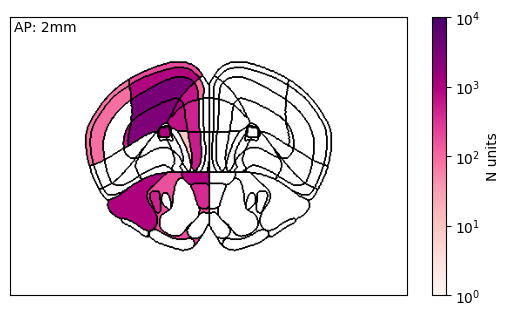

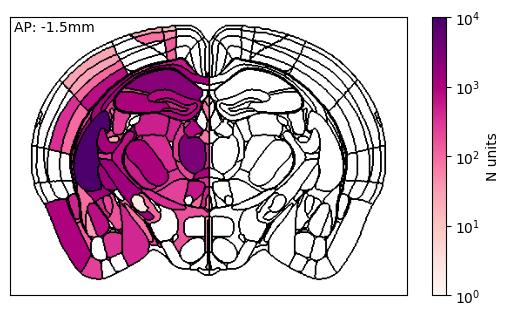

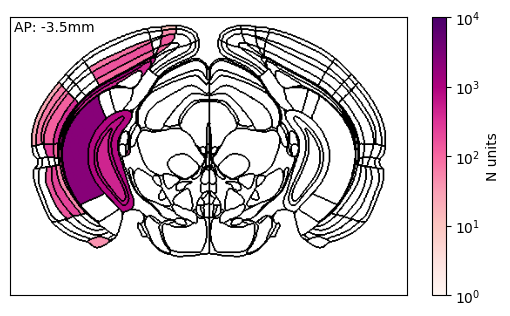

In [97]:
for ap_coord in ap_coords:
    fig, ax, cbar = anatomyplots.plot_scalar_on_slice(
        region_counts.index, 
        np.log10(region_counts.values),
        coord=ap_coord * 1000,  # in um
        background='boundary',
        atlas=atlas,
        clevels=[0, 4],
        cmap=cmap,
        show_cbar=True,
    )
    ax.text(0.01, 0.95, f'AP: {ap_coord}mm', transform=ax.transAxes)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax_pos = ax.get_position()  # returns [left, bottom, width, height]
    cbar_pos = cbar.ax.get_position()
    cbar.ax.set_position([cbar_pos.x0, ax_pos.y0, cbar_pos.width, ax_pos.height])
    cbar.set_ticks(np.linspace(0, 4, 5))
    cbar.set_ticklabels(['$10^{%d}$' % tick for tick in np.linspace(0, 4, 5)])
    cbar.set_label('N units')

In [9]:
# Make a query and load spike times
eid = 'a7a4a70f-57ae-4586-bb2d-37422deca541'  # pick a recording session
df_session = df_units.query('eid == @eid')
df_spikes = io.load_units('data/spikes', df_session['uuid'])  # load the spike times

# Control data

In [25]:
df_bwm = io.fetch_BWM_task_starts(one)

100%|███████████████████████████████████████| 1068/1068 [02:23<00:00,  7.45it/s]


In [3]:
df_bwm = pd.read_csv('metadata/BWM_task_starts.csv')

Sessions with pre-task period > 5.00min: 26


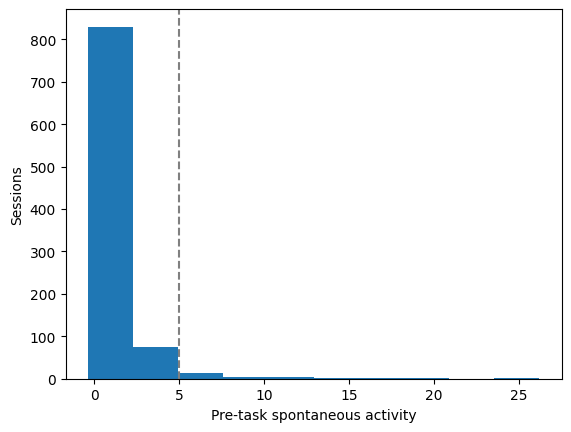

In [4]:
cutoff = 300 

fig, ax = plt.subplots()
ax.hist(df_bwm['task_start'] / 60)
ax.axvline(cutoff / 60, ls='--', color='gray')
ax.set_ylabel('Sessions')
ax.set_xlabel('Pre-task spontaneous activity')

df_controls = df_bwm.query('task_start > @cutoff')
print(f'Sessions with pre-task period > {cutoff / 60:.2f}min: {len(df_controls)}')

In [5]:
df_insertions_bwm = io.fetch_BWM_insertions(one, df_controls)

100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 681.65it/s]


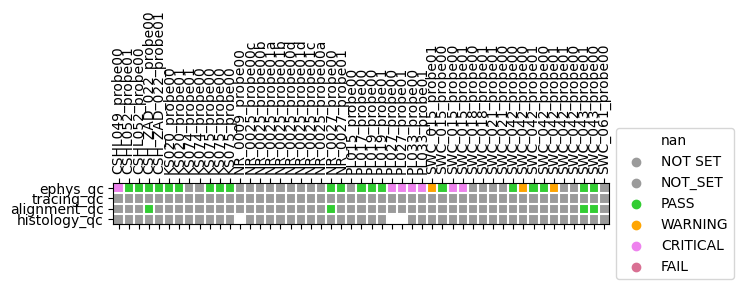

In [6]:
# QC grid plot
qc_columns = [col for col in df_insertions_bwm.columns if col.endswith('_qc')]
xticklabels = ['subject', 'probe']
ax = plots.qc_grid(df_insertions_bwm, qc_columns, xticklabels=xticklabels)

In [ ]:
df_insertions_bwm = pd.read_csv(paths['BWM_insertions'])
df_spikes_bwm = io.fetch_units(one, df_insertions_bwm, uuid_file=paths['BWM_units'], spike_file=paths['BWM_spikes'])

  0%|                                                    | 0/49 [00:00<?, ?it/s]

2025-03-11 17:52:39 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00


  2%|▉                                           | 1/49 [00:05<04:09,  5.20s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe01/pykilosort/spikes.amps.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe01/pykilosort/spikes.clusters.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe01/pykilosort/#2024-05-06#/spikes.depths.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe01/pykilosort/#2024-05-06#/spikes.times.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:5

2025-03-11 17:56:14 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00


 27%|███████████▍                               | 13/49 [03:38<03:41,  6.14s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-11 17:56:37 WARNING  one.py:359  Histology tracing for probe00c does not exist. No channels for probe00c


 29%|████████████▎                              | 14/49 [04:00<06:25, 11.01s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie

2025-03-11 17:56:55 WARNING  one.py:359  Histology tracing for probe00b does not exist. No channels for probe00b


 31%|█████████████▏                             | 15/49 [04:19<07:31, 13.29s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-11 17:57:42 WARNING  one.py:359  Histology tracing for probe01a does not exist. No channels for probe01a


 33%|██████████████                             | 16/49 [05:05<12:50, 23.34s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-11 17:57:57 WARNING  one.py:359  Histology tracing for probe01b does not exist. No channels for probe01b


 35%|██████████████▉                            | 17/49 [05:20<11:07, 20.87s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-11 17:58:11 WARNING  one.py:359  Histology tracing for probe00d does not exist. No channels for probe00d


 37%|███████████████▊                           | 18/49 [05:34<09:42, 18.79s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-11 17:58:29 WARNING  one.py:359  Histology tracing for probe01d does not exist. No channels for probe01d


 39%|████████████████▋                          | 19/49 [05:53<09:17, 18.59s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-11 17:58:46 WARNING  one.py:359  Histology tracing for probe01c does not exist. No channels for probe01c


 41%|█████████████████▌                         | 20/49 [06:10<08:46, 18.17s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-11 17:59:06 WARNING  one.py:359  Histology tracing for probe00a does not exist. No channels for probe00a


 43%|██████████████████▍                        | 21/49 [06:30<08:46, 18.79s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.amps.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.clusters.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.depths.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/spikes.times.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:5

In [ ]:
df_spikes_bwm = pd.read_csv('data/BWM_units.csv')